#### Imports

In [311]:
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
import queue
import statistics 
from queue import PriorityQueue
from tqdm import tqdm 
from collections import deque
from time import time

# RQ1
----

### Building the graph

In [2]:
G = nx.MultiDiGraph()
nodes = defaultdict(dict)

In [3]:
names = 'wiki-topcats-page-names.txt'
categories = 'wiki-topcats-categories.txt'
links = 'wikigraph_reduced.csv'

In [6]:
# multiplecat = {page_number = [list_of_categories]}

categories_list = defaultdict(list)
multiplecat = defaultdict(list)

with open(categories) as file:
    
    for line in file:
        line = line.split()
        cat = line[0].split(':')[1].strip(';')
        pages = list(map(int, line[1:len(line)]))
        
        # Filtering categories
        if len(pages) >= 5000 and len(pages) <= 30000:
            categories_list[cat] = pages
            
            for i in range(len(pages)):
                multiplecat[pages[i]].append(cat)

In [ ]:
remaining = list(categories_list.keys())

In [7]:
# Selecting at random one categories when a page belong to more than one

for page in multiplecat.keys():
    if len(multiplecat[page]) != 1:
        nodes[page]['category'] = multiplecat[page][random.randint(0,len(multiplecat[page])-1)]
    else:
        nodes[page]['category'] = multiplecat[page][0]

In [8]:
# nodes = {{page_number: {'name': page_name, 'category': page_category}}

with open(names) as file:
    for line in file:
        line = line.split()
        number = int(line[0])
        name = ' '.join(line[1:])
        if number in multiplecat.keys():
            nodes[number]['name'] = name

In [9]:
# adding nodes from the format 
# [(page_number, {'name': page_name, 'category': page_category})]

for key in nodes.keys():
    G.add_nodes_from([(int(key), nodes[key])])

In [10]:
with open(links) as file:
    file.readline()
    for line in file:
        line = line.split()
        origin = int(line[1])
        destination = int(line[2])
        if origin in nodes.keys() and destination in nodes.keys():
            G.add_edges_from([(origin,destination)])

----

The graph is directed because the web links are directional by definition. In addition we can check it by viewing that the number of unique origins is different from the number of unique destinations as we can see below. Furthermore, we already know from the assignment text that the nodes are categorized in *sources* and *targets*.  

In [14]:
df = pd.read_csv(links, sep='\t')
df.drop({'Unnamed: 0'},axis=1,inplace=True)
df.rename(columns={'0':'origin', '1':'destination'}, inplace=True)

In [15]:
df.head()

,origin,destination
0,95,1185516
1,108,1059989
2,108,1062426
3,108,1161925
4,134,541222


In [16]:
df.origin.nunique() == df.destination.nunique()

False

------

In [13]:
V = G.number_of_nodes()

In [14]:
E = G.number_of_edges()

In [15]:
print('We have a graph containing',V,'articles and',E,'hyperlinks.')

We have a graph containing 149794 articles and 483094 hyperlinks.


In [16]:
print('The average number of links per page is:', round(E/V,4))

The average number of links per page is: 3.2251


In [17]:
print('The graph density is',E/(V*(V-1)))

The graph density is 2.153008313619922e-05


A graph is dense if the number of edges is close to the maximal number of edges that it can have. For directed graph that number is $$ M^* = {2\cdot {|V| \choose 2}}$$ In other word the graph is dense if the ratio $|E|/M^*$ is close to 1. In our case we can affirm that the graph is sparse. 

-----
#### Nodes degree distribution

In [79]:
in_degrees = [G.in_degree(n) for n in G.nodes()]
out_degrees = [G.out_degree(n) for n in G.nodes()]

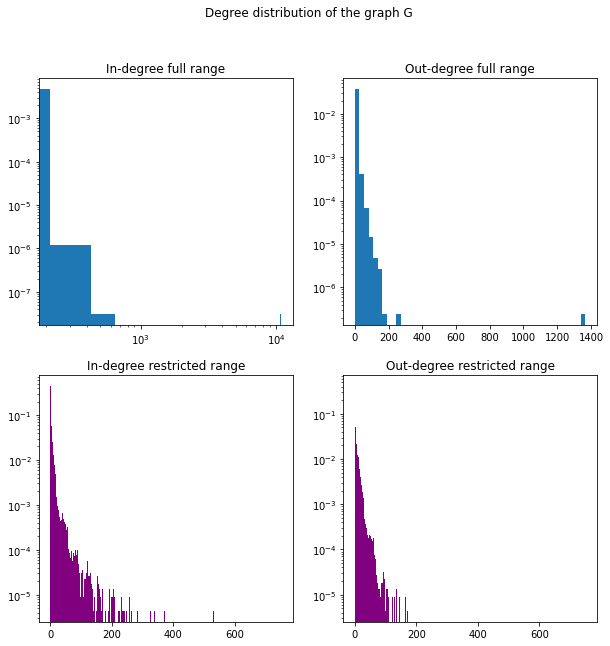

In [82]:
fig, axs = plt.subplots(2,2, figsize=(10,10))
plt.rc('legend', fontsize=6)   
fig.suptitle('Degree distribution of the graph G')

axs[0,0].set_xscale('log')
axs[0,0].hist(in_degrees, log = True, density = True, bins = 50)
axs[0,0].set_title('In-degree full range')

axs[1,0].hist(in_degrees, log = True, density = True, bins = 500, 
            range=(0,750), color = 'purple')
axs[1,0].set_title('In-degree restricted range')

axs[0,1].hist(out_degrees, log = True, density = True, bins = 50)
axs[0,1].set_title('Out-degree full range')

axs[1,1].hist(out_degrees, log = True, density = True, bins = 500, 
            range=(0,750), color = 'purple')
axs[1,1].set_title('Out-degree restricted range')

plt.show()

We plotted the degree distributions for the indegrees and the outdegrees. The first two plots are considering the whole range on the $x$-axis and the second ones are focused on the small subset of the axis that contains the most of the values. Moreover, the first plot is on the log scale. 

We can see that the degree distribution has most of its value before 300, but also a long tail due to the outliers. In addition it seems that the distribution follows a power law $p\sim k^\alpha$.

# RQ2
-----

In order to find the set of pages that we can reach in `nr_clicks` we search for those nodes that are connected between themselves (beeing origin and destination) and that are at a specific distance from the original page. 

In [17]:
def RQ2(page, nr_clicks):
    reachable = []
    new_nodes = [page] # Starting page
    for i in range(nr_clicks):
         # Nodes that we can reach from the new_nodes in one click
        a = list(df.loc[df["origin"].isin(new_nodes)]["destination"]) 
        
        # Add those nodes to the reachable 
        reachable.extend(a)
        
        # Update new_nodes
        new_nodes = a
        
    return pd.DataFrame(list(set(reachable)))

In [18]:
RQ2(95,3)

,0
0,1595904
1,1182721
2,1061891
3,1067523
4,1060361
...,...
126,1058280
127,1761772
128,139762
129,1061882


# RQ3
-----

Let $C$ be the chosen category, $S$ the subset of pages inside that category, $G_C$ the subgraph induced by $C$ and $\hat v$ the most central node according to the indegree cetrality. In order to solve `RQ3` we implemented an heuristic that creates a spanning tree $T$ from $\hat v$ to all the pages in $S$. Now, for every node $u$ in $T$ we can have two cases:
1. the node $u$ has at least an out edge, so it is part of a path;
2. the node $u$ does not have an out edge, so it is a dead end.

In the second case, if $\exists(u,w)\in G_C$ with $w\in T$, such that if we add $(u,w)$ to $T$ it is not a dead end anymore, we can add $(u,w)$ to $T$. If this edge does not exists, we imagine that our surfer start again its journey at the starting page, so we add an edge from $u$ to $\hat v$.  

In [111]:
print(', '.join(remaining))

English_footballers, The_Football_League_players, Association_football_forwards, Association_football_midfielders, Association_football_defenders, Harvard_University_alumni, Major_League_Baseball_pitchers, Members_of_the_United_Kingdom_Parliament_for_English_constituencies, Indian_films, Year_of_death_missing, Rivers_of_Romania, Main_Belt_asteroids, Asteroids_named_for_people, English-language_films, American_films, American_television_actors, American_film_actors, Debut_albums, Black-and-white_films, Year_of_birth_missing, Place_of_birth_missing_(living_people)


In [232]:
def BFS(G,v):
    q = deque()
    dist = dict()
    paths = defaultdict(list)
    
    visited = [v]
    dist[v] = 0
    paths[v].append(v)
    
    q.append(v)
    while len(q) != 0:
        v = q.pop()
        for u in G.neighbors(v):
            if u not in visited:
                visited.append(u)
                dist[u] = dist[v] + 1
                paths[u] += paths[v] + [u]
                q.append(u)
                
    return dist, paths

In [22]:
def categoryGraph(G,C):
    
    out = nx.MultiDiGraph()
    
    for node in G.nodes():
        cat = G.nodes[node]['category']
        if cat == C:
            out.add_nodes_from([(int(node), nodes[node])])
            
    new_edges = []
    for edge in G.edges():
        if edge[0] in out.nodes() and edge[1] in out.nodes():
            new_edges.append(edge)
    out.add_edges_from(new_edges)
    
    return out

In [23]:
# Dummy function to initialize default dict with zeros
def zero():
    return 0

In [24]:
def most_central_article(subset):
    d = defaultdict(zero)
    n_nodes = len(df)
    for edge in subset.edges():
        d[edge[1]] += 1
    out = max(d, key=d.get)
    return out

In [66]:
def RQ3(G,C,S=None):
    
    # nG is the graph with all the nodes belonging to one category
    nG = categoryGraph(G,C)
    v = most_central_article(nG)
    
    # All shortest paths from v
    _, paths = BFS(nG,v)
    
    # If the set of pages is not given in input
    if S == None:
        S = set(random.sample(paths.keys(), 100))
        S.add(v)
    
    # Checking connectivity, if there is a node of S
    # there is a node of S that we cannot reach from v 
    # return 'Not possible'
    if not set(paths.keys()).issuperset(S):
        return 'Not possible'
    
    # Creating the minimum tree that reaches all nodes in S from v
    pathGraph = nx.DiGraph()
    for node in paths.keys():
        if node in S:
            pathGraph.add_nodes_from([(int(node), nodes[node])]) 
    
    for node in paths.keys():
        if node in S:
            for i in range(len(paths[node])-1):
                pathGraph.add_edge(paths[node][i],paths[node][i+1])
    
    # Now we add edges until we have a path
    new_edges = []
    for node in pathGraph:
        
        # If the node is a dead end we add the first edge of nG that goes from that node to the tree
        if len(pathGraph.out_edges(node)) == 0:
            found = False
            for edge in nG.out_edges(node):
                if edge[1] in pathGraph.nodes:
                    new_edges.append((edge[0],edge[1]))
                    found = True
                    break
                    
            # If an edge from that node to the tree does not exists we add an edge that reconnect to v
            if found == False:
                new_edges.append((node,v))
               
    pathGraph.add_edges_from(new_edges)       
    
    print('---------------------------------------------')
    print('The approximated number of clicks is', pathGraph.number_of_edges())

In [67]:
RQ3(G,'Harvard_University_alumni', None)

---------------------------------------------
The approximated number of clicks is 418


# RQ4
----

In [276]:
# Creates subgraph induced by two subcategories

def subGraph(G,C1,C2):
    out = nx.MultiDiGraph()

    for node in G.nodes():
        cat = G.nodes[node]['category']
        if cat == C1 or cat == C2:
            out.add_nodes_from([(int(node), nodes[node])])
            
    new_edges = []
    for edge in G.edges():
        if edge[0] in out.nodes() and edge[1] in out.nodes():
            new_edges.append(edge)
            
    out.add_edges_from(new_edges)       
            
    return out

In [304]:
# Performs contraction of an edge

def contract(G, del_edge):
    to_keep = del_edge[1]
    to_delete =  del_edge[0]
    
    edges = G.edges(to_delete)
    to_add = []
    for edge in edges:
        if edge[1] != to_keep:
            to_add.append((edge[1], to_keep))
            
    G.remove_node(to_delete)
    G.add_edges_from(to_add)

In [305]:
def Karger(G, N = None):
    
    # N of iterations, if not given in input uses the optimal number
    if N == None:
        n = len(G.nodes)
        N = n**2*np.log(n)
        
    results = []
    for i in range(int(N)):
        nG = G.to_undirected().copy()
    
        while nG.number_of_nodes() > 2:
            if nG.number_of_edges() > 1:
                deleted_edge = random.choice(list(nG.edges()))
                contract(nG, deleted_edge) 
            else:
                return 0
            print(nG.number_of_nodes(), nG.number_of_edges())

        results.append(len(list(nG.edges())))
        
    return min(results)

In [306]:
def RQ4(G,C1,C2):
    subG = subGraph(G,C1,C2)
    subG.remove_nodes_from(list(nx.isolates(subG)))

    out = 'The Min-Cut between ' + C1 + ' and ' + C2 + ' is ' + str(Karger(subG,1))
    return out

In [307]:
C1 = 'The_Football_League_players' 
C2 = 'English_footballers'

In [308]:
RQ4(G,C1,C2)

6569 17977
6568 17976
6567 17975
6566 17974
6565 17973
6564 17972
6563 17971
6562 17970
6561 17969
6560 17968
6559 17967
6558 17966
6557 17965
6556 17964
6555 17963
6554 17962
6553 17961
6552 17960
6551 17959
6550 17958
6549 17957
6548 17956
6547 17955
6546 17954
6545 17953
6544 17952
6543 17951
6542 17950
6541 17949
6540 17948
6539 17947
6538 17946
6537 17945
6536 17944
6535 17943
6534 17942
6533 17941
6532 17940
6531 17939
6530 17938
6529 17937
6528 17936
6527 17935
6526 17934
6525 17933
6524 17932
6523 17931
6522 17930
6521 17929
6520 17928
6519 17927
6518 17926
6517 17925
6516 17924
6515 17923
6514 17922
6513 17921
6512 17920
6511 17919
6510 17918
6509 17917
6508 17916
6507 17915
6506 17914
6505 17913
6504 17912
6503 17911
6502 17910
6501 17909
6500 17908
6499 17906
6498 17905
6497 17904
6496 17902
6495 17901
6494 17900
6493 17899
6492 17898
6491 17897
6490 17896
6489 17895
6488 17894
6487 17893
6486 17892
6485 17891
6484 17890
6483 17889
6482 17888
6481 17885
6480 17884
6479 17883

5824 17086
5823 17085
5822 17081
5821 17080
5820 17078
5819 17077
5818 17076
5817 17075
5816 17074
5815 17073
5814 17072
5813 17071
5812 17061
5811 17060
5810 17056
5809 17051
5808 17050
5807 17047
5806 17046
5805 17045
5804 17044
5803 17042
5802 17041
5801 17040
5800 17039
5799 17038
5798 17036
5797 17034
5796 17033
5795 17032
5794 17031
5793 17030
5792 17029
5791 17028
5790 17027
5789 17026
5788 17024
5787 17023
5786 17015
5785 17014
5784 17013
5783 17011
5782 17010
5781 17009
5780 17008
5779 17007
5778 17006
5777 17005
5776 17004
5775 17003
5774 17001
5773 17000
5772 16999
5771 16997
5770 16996
5769 16995
5768 16994
5767 16992
5766 16991
5765 16986
5764 16985
5763 16984
5762 16983
5761 16982
5760 16980
5759 16979
5758 16978
5757 16977
5756 16976
5755 16975
5754 16974
5753 16973
5752 16972
5751 16970
5750 16969
5749 16968
5748 16967
5747 16966
5746 16965
5745 16964
5744 16963
5743 16962
5742 16961
5741 16960
5740 16953
5739 16952
5738 16951
5737 16950
5736 16945
5735 16944
5734 16942

5076 13727
5075 13725
5074 13724
5073 13723
5072 13700
5071 13673
5070 13663
5069 13662
5068 13661
5067 13659
5066 13658
5065 13657
5064 13656
5063 13655
5062 13654
5061 13651
5060 13650
5059 13649
5058 13648
5057 13645
5056 13644
5055 13642
5054 13641
5053 13640
5052 13639
5051 13638
5050 13637
5049 13636
5048 13632
5047 13631
5046 13627
5045 13626
5044 13625
5043 13624
5042 13620
5041 13619
5040 13618
5039 13615
5038 13614
5037 13612
5036 13610
5035 13609
5034 13596
5033 13595
5032 13594
5031 13593
5030 13592
5029 13567
5028 13565
5027 13564
5026 13563
5025 13562
5024 13561
5023 13560
5022 13555
5021 13554
5020 13535
5019 13534
5018 13520
5017 13519
5016 13510
5015 13509
5014 13508
5013 13507
5012 13499
5011 13497
5010 13494
5009 13493
5008 13487
5007 13486
5006 13485
5005 13484
5004 13440
5003 13438
5002 13437
5001 13436
5000 13435
4999 13434
4998 13433
4997 13432
4996 13431
4995 13430
4994 13429
4993 13428
4992 13426
4991 13425
4990 13423
4989 13392
4988 13391
4987 13389
4986 13388

4327 10508
4326 10503
4325 10502
4324 10501
4323 10500
4322 10481
4321 10480
4320 10466
4319 10464
4318 10461
4317 10460
4316 10458
4315 10446
4314 10444
4313 10440
4312 10421
4311 10420
4310 10419
4309 10417
4308 10414
4307 10410
4306 10409
4305 10408
4304 10406
4303 10404
4302 10403
4301 10402
4300 10394
4299 10393
4298 10390
4297 10388
4296 10387
4295 10386
4294 10384
4293 10380
4292 10379
4291 10376
4290 10374
4289 10373
4288 10369
4287 10365
4286 10364
4285 10363
4284 10362
4283 10343
4282 10342
4281 10339
4280 10337
4279 10314
4278 10312
4277 10310
4276 10309
4275 10308
4274 10305
4273 10304
4272 10303
4271 10300
4270 10292
4269 10285
4268 10281
4267 10280
4266 10278
4265 10277
4264 10273
4263 10269
4262 10267
4261 10264
4260 10252
4259 10251
4258 10249
4257 10248
4256 10247
4255 10246
4254 10245
4253 10244
4252 10239
4251 10238
4250 10234
4249 10231
4248 10227
4247 10213
4246 10212
4245 10190
4244 10189
4243 10188
4242 10187
4241 10185
4240 10173
4239 10172
4238 10171
4237 10165

3516 7409
3515 7407
3514 7404
3513 7402
3512 7398
3511 7392
3510 7383
3509 7381
3508 7380
3507 7379
3506 7376
3505 7369
3504 7368
3503 7366
3502 7364
3501 7359
3500 7358
3499 7352
3498 7350
3497 7349
3496 7345
3495 7343
3494 7340
3493 7339
3492 7338
3491 7337
3490 7335
3489 7334
3488 7313
3487 7312
3486 7311
3485 7310
3484 7301
3483 7294
3482 7293
3481 7292
3480 7291
3479 7288
3478 7287
3477 7285
3476 7284
3475 7283
3474 7280
3473 7278
3472 7276
3471 7273
3470 7272
3469 7271
3468 7270
3467 7269
3466 7267
3465 7265
3464 7264
3463 7262
3462 7260
3461 7255
3460 7251
3459 7250
3458 7249
3457 7228
3456 7227
3455 7226
3454 7224
3453 7223
3452 7222
3451 7220
3450 7215
3449 7214
3448 7213
3447 7212
3446 7211
3445 7210
3444 7209
3443 7207
3442 7205
3441 7204
3440 7203
3439 7199
3438 7198
3437 7196
3436 7193
3435 7192
3434 7188
3433 7185
3432 7175
3431 7173
3430 7167
3429 7166
3428 7162
3427 7161
3426 7159
3425 7158
3424 7157
3423 7156
3422 7152
3421 7150
3420 7149
3419 7146
3418 7145
3417 7139


2692 4856
2691 4854
2690 4852
2689 4845
2688 4844
2687 4843
2686 4829
2685 4827
2684 4826
2683 4825
2682 4824
2681 4816
2680 4815
2679 4812
2678 4811
2677 4810
2676 4809
2675 4807
2674 4804
2673 4800
2672 4796
2671 4789
2670 4787
2669 4785
2668 4783
2667 4782
2666 4781
2665 4780
2664 4779
2663 4776
2662 4773
2661 4769
2660 4765
2659 4763
2658 4761
2657 4751
2656 4743
2655 4742
2654 4741
2653 4740
2652 4738
2651 4736
2650 4735
2649 4733
2648 4729
2647 4727
2646 4726
2645 4725
2644 4724
2643 4723
2642 4722
2641 4721
2640 4720
2639 4719
2638 4717
2637 4716
2636 4715
2635 4714
2634 4713
2633 4712
2632 4711
2631 4707
2630 4706
2629 4705
2628 4702
2627 4699
2626 4698
2625 4695
2624 4689
2623 4675
2622 4674
2621 4673
2620 4672
2619 4671
2618 4670
2617 4666
2616 4662
2615 4656
2614 4655
2613 4654
2612 4653
2611 4652
2610 4650
2609 4646
2608 4645
2607 4644
2606 4643
2605 4641
2604 4637
2603 4636
2602 4632
2601 4631
2600 4630
2599 4627
2598 4626
2597 4625
2596 4624
2595 4623
2594 4619
2593 4618


1848 2621
1847 2620
1846 2619
1845 2614
1844 2613
1843 2608
1842 2606
1841 2605
1840 2604
1839 2603
1838 2600
1837 2599
1836 2591
1835 2586
1834 2585
1833 2584
1832 2578
1831 2571
1830 2570
1829 2567
1828 2564
1827 2562
1826 2560
1825 2559
1824 2558
1823 2557
1822 2555
1821 2554
1820 2550
1819 2540
1818 2537
1817 2536
1816 2535
1815 2533
1814 2527
1813 2526
1812 2525
1811 2522
1810 2519
1809 2515
1808 2513
1807 2512
1806 2511
1805 2510
1804 2508
1803 2500
1802 2499
1801 2497
1800 2495
1799 2493
1798 2492
1797 2491
1796 2490
1795 2489
1794 2488
1793 2486
1792 2480
1791 2476
1790 2475
1789 2474
1788 2473
1787 2472
1786 2471
1785 2469
1784 2468
1783 2467
1782 2464
1781 2463
1780 2460
1779 2457
1778 2456
1777 2453
1776 2451
1775 2450
1774 2448
1773 2444
1772 2443
1771 2440
1770 2439
1769 2434
1768 2433
1767 2432
1766 2430
1765 2429
1764 2425
1763 2420
1762 2419
1761 2417
1760 2416
1759 2413
1758 2412
1757 2411
1756 2408
1755 2407
1754 2405
1753 2404
1752 2402
1751 2401
1750 2400
1749 2399


1024 1067
1023 1065
1022 1064
1021 1062
1020 1061
1019 1060
1018 1058
1017 1057
1016 1056
1015 1053
1014 1052
1013 1050
1012 1049
1011 1043
1010 1041
1009 1040
1008 1038
1007 1034
1006 1033
1005 1030
1004 1029
1003 1028
1002 1027
1001 1024
1000 1023
999 1021
998 1020
997 1019
996 1017
995 1014
994 1013
993 1012
992 1011
991 1010
990 1009
989 1008
988 1007
987 1006
986 1005
985 1003
984 1002
983 1000
982 998
981 997
980 996
979 995
978 994
977 993
976 992
975 991
974 989
973 984
972 983
971 982
970 980
969 979
968 977
967 972
966 970
965 969
964 968
963 967
962 966
961 965
960 964
959 963
958 961
957 960
956 956
955 954
954 952
953 951
952 950
951 949
950 948
949 947
948 945
947 944
946 942
945 941
944 940
943 937
942 936
941 934
940 933
939 932
938 931
937 930
936 929
935 928
934 927
933 924
932 923
931 922
930 921
929 920
928 919
927 917
926 916
925 915
924 914
923 912
922 911
921 910
920 909
919 908
918 907
917 906
916 903
915 902
914 901
913 900
912 899
911 898
910 897
909 896
908 8

'The Min-Cut between The_Football_League_players and English_footballers is 0'

# RQ5
----

In this exercise we compute the pairwise distances between the categories by using `BFS`. In order to spare us some time, for each couple of categories, a subgraph induced by those two is created and the distances are evaluated each time on that. This could take about 20 minutes.

In [327]:
def RQ5(G,C):
    t1 = time()
    
    dist = dict()
    categories = set(remaining).difference(set(C))
    scores = defaultdict(list)
    origins = [v for v in G if G.nodes[v]['category'] == C]
    
    i = 1
    print('Computing distances...')
    for cat in categories:
        print(i, 'out of',len(categories),'categories.')
        dist_from_cat = []
        nG = subGraph(G,C,cat)
        
        for node in origins:
            bfs_v = BFS(nG, node)[0] # All distances from each node in the main category C
            
            # We exclude in the computation the nodes that are not reachable 
            bfs_v = {k:v for k,v in bfs_v.items() if v != np.infty and nG.nodes[k]['category'] == cat} 
            dist_from_cat += list(bfs_v.values())
            
        scores[cat] += dist_from_cat    
        i += 1
    
    # At this point we have, for each category, a vector containing all the distances
    medians = dict()
    for k,v in scores.items():
        if len(v) > 0:
            medians[k] = statistics.median(v)
        else:
            # If the categories are disconnected we consider the distance as infinity
            medians[k] = np.infty
    
    # Sorting
    medians = {k: v for k, v in sorted(medians.items(), key=lambda item: item[1])}
    
    t2 = time()
    print('Reached solution in %f' %(t2-t1))
    return medians

In [328]:
RQ5(G,'Association_football_forwards')

Computing distances...
1 out of 20 categories.
2 out of 20 categories.
3 out of 20 categories.
4 out of 20 categories.
5 out of 20 categories.
6 out of 20 categories.
7 out of 20 categories.
8 out of 20 categories.
9 out of 20 categories.
10 out of 20 categories.
11 out of 20 categories.
12 out of 20 categories.
13 out of 20 categories.
14 out of 20 categories.
15 out of 20 categories.
16 out of 20 categories.
17 out of 20 categories.
18 out of 20 categories.
19 out of 20 categories.
20 out of 20 categories.
Reached solution in 1381.582360


{'Debut_albums': 1,
 'Year_of_birth_missing': 2.0,
 'Major_League_Baseball_pitchers': 2,
 'American_films': 4.0,
 'Rivers_of_Romania': 5,
 'Black-and-white_films': 13.0,
 'Year_of_death_missing': 15.0,
 'Association_football_forwards': 26,
 'Place_of_birth_missing_(living_people)': 30,
 'Association_football_defenders': 48,
 'Association_football_midfielders': 75,
 'English-language_films': 109.0,
 'English_footballers': 111.0,
 'The_Football_League_players': 133,
 'American_television_actors': 138,
 'American_film_actors': 180.0,
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies': 611.0,
 'Main_Belt_asteroids': inf,
 'Indian_films': inf,
 'Harvard_University_alumni': inf}

# RQ6
---

#### 1. Create the new graph

We created a new graph where each node represents a category and there is an edge between two nodes if in original graph there was at least one edge from a node in that category to one in another category. 

In [84]:
catG = nx.DiGraph()

In [85]:
i = 0
dic = dict()
for cat in remaining:
    catG.add_nodes_from([(i, {'category': cat})])
    dic[cat] = i
    i += 1

In [86]:
for cat in remaining:
    for node in categories_list[cat]:
        for edge in G.out_edges(node):
            origin_cat = G.nodes[edge[0]]['category']
            dest_cat = G.nodes[edge[1]]['category']
            if origin_cat != dest_cat:
                catG.add_edge(dic[origin_cat], dic[dest_cat])

#### 2. PageRank

In [95]:
def RQ6(G, alpha=0.15):
    
    # Creating transition matrix from adjacecy matrix
    A = nx.adjacency_matrix(G).toarray()
    sum_of_rows = A.sum(axis=1)
    A_norm = A / sum_of_rows[:, np.newaxis]  
    P = alpha * np.ones((len(A),len(A)))/len(A) + (1-alpha)*A_norm
    
    # Starting vector
    v = np.ones(len(A))/len(A)
    
    # Stop condition
    eps = 0.001
    while 1:
        v1 = v
        v = np.dot(v,P)
        if np.all(v1 - v < eps):
            break
            
    results = dict()
    
    print('|------------------|')
    print('| PageRank results |')
    print('|------------------|')
    print()
    
    for i in range(len(v)):
        # We multiplied the PR score by 100 to make it more readable but keep in mind that
        # the actual PR score is a probability that will sum up to one
        results[i] = round(v[i]*100,2)
       
    # Sorting
    for el in sorted(results.items(), key=lambda item: item[1], reverse=True):
        print('Score:', el[1], 'Category:', catG.nodes[el[0]]['category'])
        
    return results

In [96]:
results = RQ6(catG)

|------------------|
| PageRank results |
|------------------|

Score: 7.46 Category: American_films
Score: 5.54 Category: Year_of_birth_missing
Score: 5.53 Category: Year_of_death_missing
Score: 5.53 Category: American_television_actors
Score: 5.51 Category: American_film_actors
Score: 5.51 Category: Place_of_birth_missing_(living_people)
Score: 5.34 Category: English-language_films
Score: 5.29 Category: Members_of_the_United_Kingdom_Parliament_for_English_constituencies
Score: 5.24 Category: Harvard_University_alumni
Score: 5.07 Category: Association_football_forwards
Score: 5.05 Category: Debut_albums
Score: 4.77 Category: Association_football_midfielders
Score: 4.62 Category: English_footballers
Score: 4.62 Category: The_Football_League_players
Score: 4.58 Category: Association_football_defenders
Score: 4.54 Category: Black-and-white_films
Score: 3.83 Category: Indian_films
Score: 3.81 Category: Major_League_Baseball_pitchers
Score: 3.26 Category: Main_Belt_asteroids
Score: 2.73 Ca

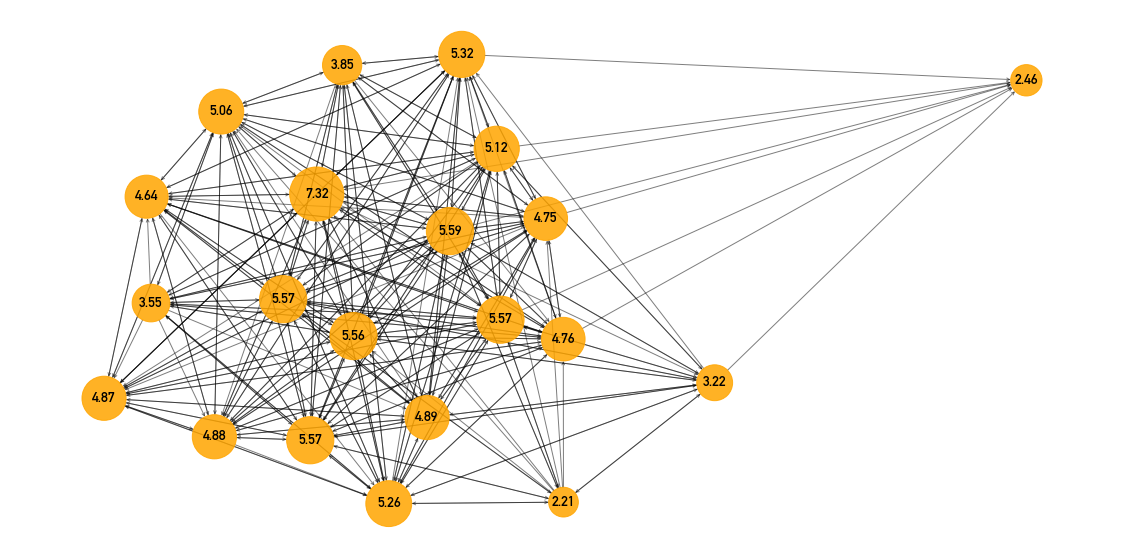

In [42]:
plt.figure(figsize=(20,10))
pos = nx.spring_layout(catG, seed=42)
d = dict(catG.degree)

node_sizes = [v * 400 for v in results.values()]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(catG, 
                               pos, 
                               node_size=node_sizes, 
                               node_color="orange",
                               alpha=0.85)

edges = nx.draw_networkx_edges(catG,
                               pos,
                               node_size=node_sizes,
                               arrowstyle= "->",
                               arrowsize= 7,
                               width= 1,
                               alpha =0.5)

labels = nx.draw_networkx_labels(catG, 
                                 pos, 
                                 font_family='DIN Alternate',
                                 labels = results,
                                 font_size=14)
                                 

ax = plt.gca()
ax.set_axis_off()
plt.show()

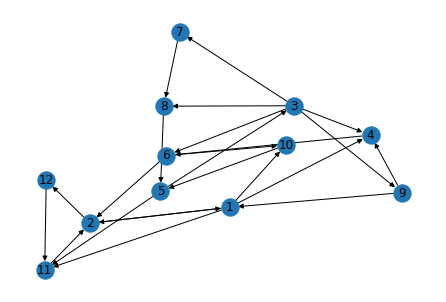

In [261]:
### KEEP FOR TESTING PURPOSES

g = nx.MultiDiGraph()
g.add_nodes_from([
    (1, {"category": "A"}),
    (2, {"category": "A"}),
    (3, {"category": "A"}),
    (4, {"category": "B"}),
    (5, {"category": "B"}),
    (6, {"category": "B"}),
    (7, {"category": "C"}),
    (8, {"category": "C"}),
    (9, {"category": "A"}),
    (10, {"category": "B"}),
    (11, {"category": "C"}),
    (12, {"category": "C"}),
])
g.add_edges_from([(1,2),(3,4),(2,1),(12,11),(8,5),
                 (5,3),(1,4),(9,4),(2,12),(5,11),
                 (9,1),(1,11),(3,8),(3,9),(11,2),
                 (10,5),(6,10),(1,10),(7,8),(6,2),
                 (3,6),(4,6),(3,7)])
nx.draw(g, with_labels= True)

In [284]:
g.edges(11, data=True)

OutMultiEdgeDataView([(11, 2, {})])